**Laborator 8**

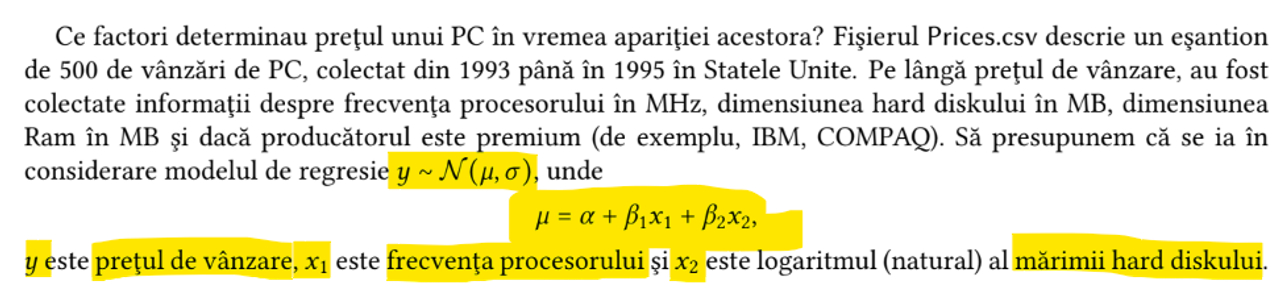

In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import pytensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


* citire date din CSV  

In [ ]:
Prices = pd.read_csv('Prices.csv')
x_1 = Prices['Speed'].values
x_2 = np.log(Prices['HardDrive'].values)
y = Prices['Price'].values
X = np.column_stack((x_1,x_2)) # matrice de caracteristici
X_mean = X.mean(axis=0, keepdims=True)
# pentru a ne face o idee asupra mediilor si dev. standard:
print(X_mean)   
print(y.mean())
print(X.std(axis=0, keepdims=True))
print(y.std())

[[52.004     5.877261]]
2248.076
[[20.12719513  0.61168344]]
563.8149574319575


* ne facem o idee despre date

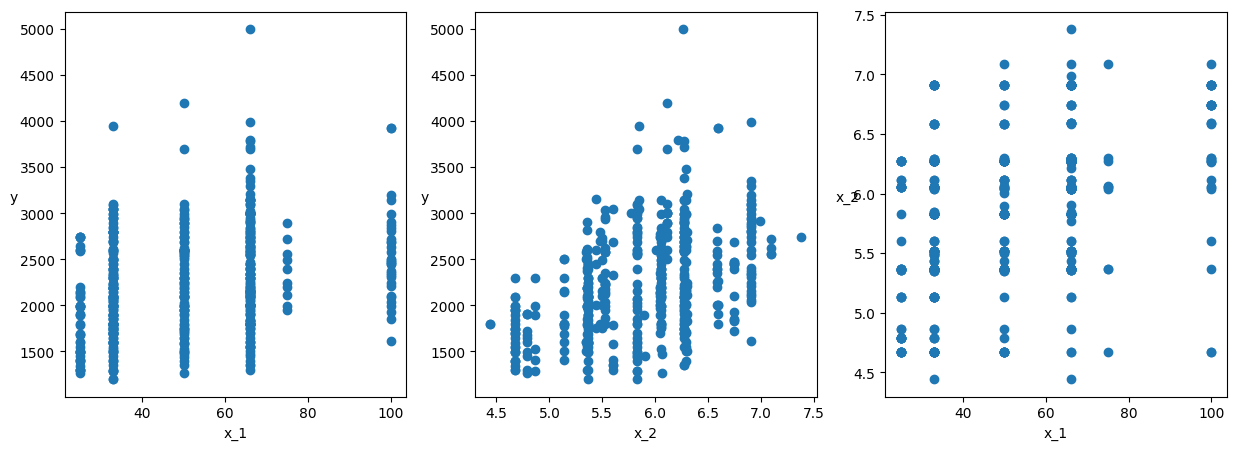

In [4]:
def scatter_plot(x, y):
    plt.figure(figsize=(15, 5))
    for idx, x_i in enumerate(x.T):
        plt.subplot(1, 3, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(1, 3, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)
scatter_plot(X, y)

**1.**

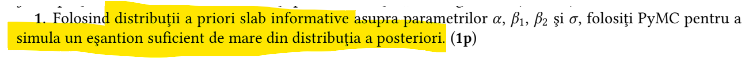

* de ce StudentT?
Motivul pentru alegerea distribuției Student-t în loc de o distribuție normală include aspecte precum robustețea la valori aberante, capacitatea de a modela variația datelor în mod mai flexibil și considerarea unei distribuții a erorilor cu cozi mai groase.

* Este o practică comună în analiza bayesiană să se ia în considerare distribuții mai robuste, cum ar fi Student-t, atunci când se lucrează cu date reale care pot conține valori atipice sau când se dorește o modelare a incertitudinii mai conservatoare.


In [5]:
with pm.Model() as model_mlr:

    # distributii a priori slab informative 
    α = pm.Normal('α', mu=0, sigma=1000)
    # am luat sigma=1000 deoarece nu am standardizat datele, 
    # iar dev. standard pentru y este f mare

    #  facem pp a priori despre coeficienții de regresie β. înainte de a vedea datele observate, modelul consideră că coeficienții β 
    # sunt în mod probabil în jurul valorii zero, dar avem o incertitudine semnificativă (dată de deviația standard mare)
    β = pm.Normal('β', mu=0, sigma=1000, shape=2) 
    #shape=2 -> β are două componente (avem 2 variabile explicative în modelul de regresie multiplă). 
    # => β este un vector bidimensional.

    # facem pp a priori despre variabilitatea erorii în cadrul modelului. distrib Half-Cauchy => posibilitatea unor devieri mari 
    # în eroarea standard, dar în mod probabil, este de așteptat ca aceasta să fie mai mică.
    ϵ = pm.HalfCauchy('ϵ', 5000) # ϵ este deviația standard a erorii, care este distribuită în mod uniform între 0 și 5000
    
    ν = pm.Exponential('ν', 1/30)
    X_shared = pm.MutableData('x_shared',X) #pentru pct. 5
    μ = pm.Deterministic('μ',α + pm.math.dot(X_shared, β))
 
    y_pred = pm.StudentT('y_pred', mu=μ, sigma=ϵ, nu=ν, observed=y)

    idata_mlr = pm.sample(1250, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ, ν]


Sampling 4 chains for 1_000 tune and 1_250 draw iterations (4_000 + 5_000 draws total) took 34 seconds.


**2.** 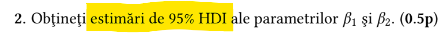

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],4.013,1.167,1.676,6.269,0.021,0.015,3219.0,3039.0,1.0
β[1],350.708,36.522,280.077,423.337,0.793,0.562,2131.0,2187.0,1.0


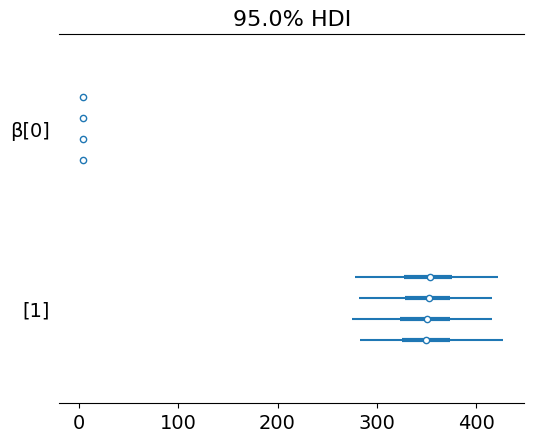

In [6]:
az.plot_forest(idata_mlr,hdi_prob=0.95,var_names=['β'])
az.summary(idata_mlr,hdi_prob=0.95,var_names=['β'])

**3.** 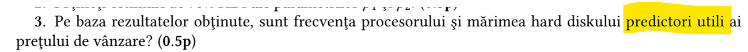

 Se vede că x1 (frecvență) are o mică influență asupra prețului (y), deoarece beta[0] este mic (în comparație cu beta[1]). Totuși, 0 nu este în intervalul hdi pentru beta[0] (și nici pentru beta[1]), deci putem lua acest parametru în calcul.

    # beta1 si beta2 corespund coeficientilor asociati frecventei procesorului si dimensiunii hard disk-ului
    intervalele HDI sunt calculate a.i sa acopere cu 95% cele mai probabile valori pentru acesti coeficienti
    intervalele HDI pentru beta1 si beta2 nu includ 0 => 
        frecventa procesorului si dimensiunea hard disk-ului sunt considerate predictori utili ai 
        pretului de vanzare al PC-urilor. adica acesti doi factori au o influenta semnificativa asupra 
        determinarii preturilor de vanzare.

**4. 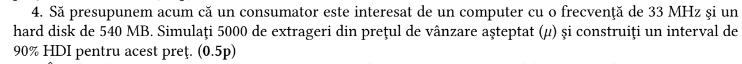


Var. 1.**

<Axes: title={'center': 'x'}>

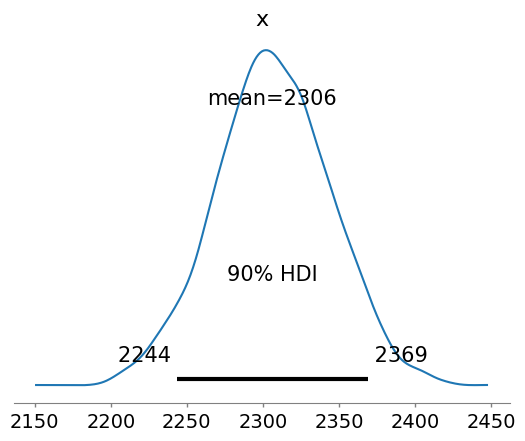

In [7]:
posterior_g = idata_mlr.posterior.stack(samples={"chain", "draw"}) #avem 5000 de extrageri in esantion (nr. draws x nr. chains)
mu = posterior_g['α']+33*posterior_g['β'][0]+np.log(540)*posterior_g['β'][1]
az.plot_posterior(mu.values,hdi_prob=0.9)

**Var. 2.**

Sampling: []


<Axes: title={'center': 'x'}>

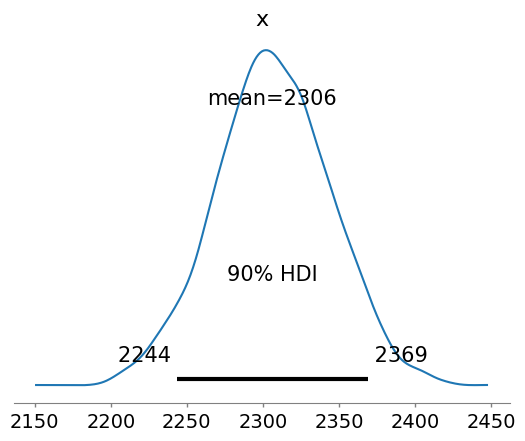

In [10]:
pm.set_data({"x_shared":[[33,np.log(540)]]}, model=model_mlr)
ppc = pm.sample_posterior_predictive(idata_mlr, var_names=["μ"], model=model_mlr)
y_ppc = ppc.posterior_predictive["μ"].stack(sample=("chain", "draw")).values
az.plot_posterior(y_ppc,hdi_prob=0.9)

**5.** 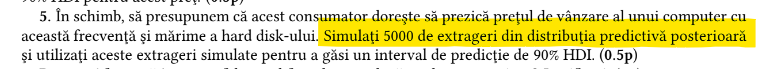

Sampling: [y_pred]


<Axes: title={'center': 'x'}>

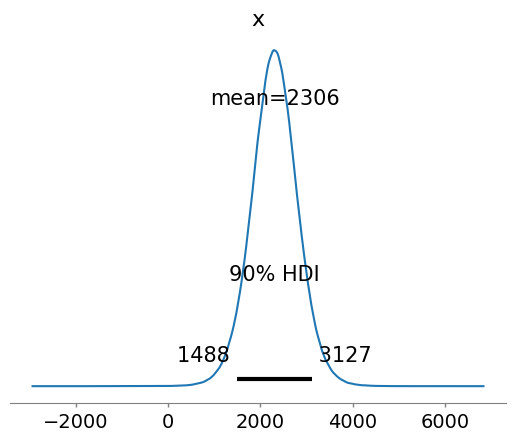

In [14]:
pm.set_data({"x_shared":[[33,np.log(540)]]}, model=model_mlr)
ppc = pm.sample_posterior_predictive(idata_mlr, model=model_mlr)
y_ppc = ppc.posterior_predictive['y_pred'].stack(sample=("chain", "draw")).values
az.plot_posterior(y_ppc,hdi_prob=0.9)

**Bonus**



In [15]:
Prices = pd.read_csv('Prices.csv')
PPrices = Prices[Prices['Premium']=='yes']
xp_1 = PPrices['Speed'].values
xp_2 = np.log(PPrices['HardDrive'].values)
yp = PPrices['Price'].values
Xp = np.column_stack((xp_1,xp_2))

In [16]:
with pm.Model() as model_premium:
    α = pm.Normal('α', mu=0, sigma=1000)
    #am luat sigma=1000 deoarece nu am standardizat datele, iar dev. standard pentru y este f. mare
    β = pm.Normal('β', mu=0, sigma=1000, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5000)
    ν = pm.Exponential('ν', 1/30)
    μ = pm.Deterministic('μ',α + pm.math.dot(Xp, β))
 
    y_prem = pm.StudentT('y_prem', mu=μ, sigma=ϵ, nu=ν, observed=yp)

    idata_prem = pm.sample(1250, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ, ν]


Sampling 4 chains for 1_000 tune and 1_250 draw iterations (4_000 + 5_000 draws total) took 32 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],3.051,1.163,0.883,5.439,0.020,0.015,3353.0,3059.0,1.0
β[1],354.632,37.049,282.563,427.231,0.792,0.560,2180.0,2265.0,1.0


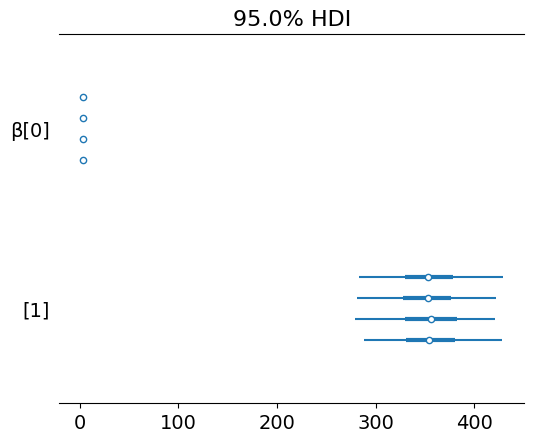

In [10]:
az.plot_forest(idata_prem,hdi_prob=0.95,var_names=['β'])
az.summary(idata_prem,hdi_prob=0.95,var_names=['β'])

#intervalul obtinut pt beta_premium este larg si poate include 0
    => atributul 'Premium' nu are mereu un impact semnificativ asupra predictiei pretului
    => un producator premium nu contribuie in mod constant la variatia preturilor PC-urilor

Observăm că intervalele HDI se intercalează, deci nu putem observa o afectare a prețului de faptul că producătorul ar fi 'premium'. Se poate vizualiza acest lucru și pe graficul de mai jos:

c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\arviz\plots\hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
C:\Users\adria\AppData\Local\Temp\ipykernel_5088\2687407476.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0." (-> color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)). The keyword argument will take precedence.
  plt.plot(xp_

Text(0, 0.5, 'y')

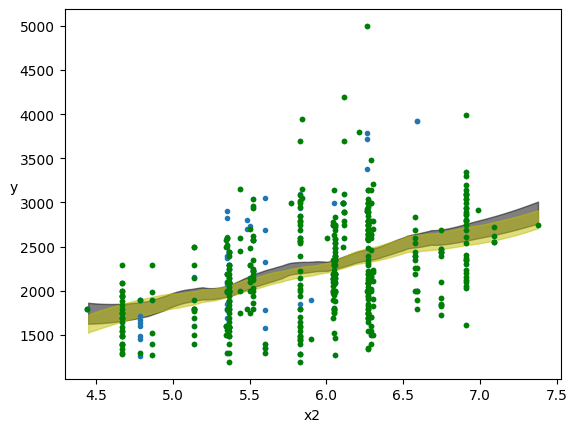

In [12]:
posterior_g = idata_mlr.posterior.stack(samples={"chain", "draw"})
posterior_prem = idata_prem.posterior.stack(samples={"chain", "draw"})
sig = az.plot_hdi(x_2, posterior_g['μ'].T, hdi_prob=0.95, color='k')
sig_prem = az.plot_hdi(xp_2, posterior_prem['μ'].T, hdi_prob=0.95, color='y')
alpha_m = posterior_g['α'].mean().item()
beta_m0 = posterior_g['β'][0].mean().item()
beta_m1 = posterior_g['β'][1].mean().item()
alpha_m_p = posterior_prem['α'].mean().item()
beta_m0_p = posterior_prem['β'][0].mean().item()
beta_m1_p = posterior_prem['β'][1].mean().item()
plt.plot(x_2, y, 'C0.')
plt.plot(xp_2, yp, 'C0.', color='g') # datele 'premium'

plt.xlabel('x2')
plt.ylabel('y', rotation=0)